In [ ]:
# Step 1: Upload kaggle.json
from google.colab import files
files.upload()  # You'll be prompted to upload the kaggle.json file

# Step 2: Setup Kaggle credentials
import os
import zipfile

os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

# Step 3: Download the dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Step 4: Unzip the dataset
with zipfile.ZipFile("creditcardfraud.zip", "r") as zip_ref:
    zip_ref.extractall("creditcard_dataset")

# Step 5: Verify contents
import os
os.listdir("creditcard_dataset")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0


['creditcard.csv']

In [ ]:
import pandas as pd
df = pd.read_csv("/content/creditcard_dataset/creditcard.csv")
df = df.drop(['Time'], axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape

(284807, 30)

In [ ]:
fraud_df=df[df['Class']==1]

In [ ]:
fraud_df.shape

(492, 30)

# Dual Generators (Exclusive)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("creditcard.csv")
df = df.drop(['Time'], axis=1)
fraud_df = df[df['Class'] == 1].drop(['Class'], axis=1)

scaler = StandardScaler()
fraud_data = scaler.fit_transform(fraud_df)

fraud_data = torch.FloatTensor(fraud_data)

class VAE(nn.Module):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(original_dim, intermediate_dim)
        self.bn1 = nn.BatchNorm1d(intermediate_dim)
        self.fc2_mean = nn.Linear(intermediate_dim, latent_dim)
        self.fc2_logvar = nn.Linear(intermediate_dim, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, intermediate_dim)
        self.bn2 = nn.BatchNorm1d(intermediate_dim)
        self.fc4 = nn.Linear(intermediate_dim, original_dim)

    def encode(self, x):
        h = torch.nn.functional.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.2)
        return self.fc2_mean(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.nn.functional.leaky_relu(self.bn2(self.fc3(z)), negative_slope=0.2)
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.utils.spectral_norm(nn.Linear(input_dim, 128))
        self.fc2 = nn.utils.spectral_norm(nn.Linear(128, 64))
        self.fc3 = nn.utils.spectral_norm(nn.Linear(64, 32))
        self.fc4 = nn.utils.spectral_norm(nn.Linear(32, 1))

    def forward(self, x):
        h = torch.nn.functional.leaky_relu((self.fc1(x)), negative_slope=0.2)
        h = torch.nn.functional.leaky_relu((self.fc2(h)), negative_slope=0.2)
        h = torch.nn.functional.leaky_relu((self.fc3(h)), negative_slope=0.2)
        return torch.sigmoid(self.fc4(h))

class VAEGAN(nn.Module):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super(VAEGAN, self).__init__()
        self.generator1 = VAE(original_dim, intermediate_dim, latent_dim)
        self.generator2 = VAE(original_dim, intermediate_dim, latent_dim)
        self.discriminator = Discriminator(original_dim)

    def forward(self, x):
        recon1, mu1, logvar1 = self.generator1(x)
        recon2, mu2, logvar2 = self.generator2(x)
        return recon1, recon2, mu1, logvar1, mu2, logvar2

# Parameters
original_dim = fraud_data.shape[1]
intermediate_dim = 128
latent_dim = 32
epochs = 200
batch_size = 128
learning_rate_g = 1e-4
learning_rate_d = 1e-4

# Instantiate models
vaegan = VAEGAN(original_dim, intermediate_dim, latent_dim)

# Optimizers
optimizer_g1 = optim.Adam(vaegan.generator1.parameters(), lr=learning_rate_g, betas=(0.5, 0.9))
optimizer_g2 = optim.Adam(vaegan.generator2.parameters(), lr=learning_rate_g, betas=(0.5, 0.9))
optimizer_d = optim.Adam(vaegan.discriminator.parameters(), lr=learning_rate_d, betas=(0.5, 0.9))

# Loss functions
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.005 * KLD

def disc_loss(real_pred, fake_pred):
    real_labels = torch.full_like(real_pred, 0.9)
    fake_labels = torch.full_like(fake_pred, 0.1)
    real_loss = nn.functional.binary_cross_entropy(real_pred, real_labels)
    fake_loss = nn.functional.binary_cross_entropy(fake_pred, fake_labels)
    return real_loss + fake_loss

def gen_loss(fake_pred):
    return nn.functional.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred) * 0.9)

train_loader = DataLoader(TensorDataset(fraud_data), batch_size=batch_size, shuffle=True)

import matplotlib.pyplot as plt

disc_losses = []
g1_losses = []
g2_losses = []

for epoch in range(epochs):
    vaegan.train()
    epoch_disc_loss = 0
    epoch_g1_loss = 0
    epoch_g2_loss = 0

    for batch_idx, (data,) in enumerate(train_loader):
        data = data.clone().detach()

        recon1, recon2, mu1, logvar1, mu2, logvar2 = vaegan(data)

        # Train Discriminator
        optimizer_d.zero_grad()
        real_pred = torch.clamp(vaegan.discriminator(data), 1e-7, 1 - 1e-7)
        fake_pred1 = torch.clamp(vaegan.discriminator(recon1.detach()), 1e-7, 1 - 1e-7)
        fake_pred2 = torch.clamp(vaegan.discriminator(recon2.detach()), 1e-7, 1 - 1e-7)
        disc_loss_val = disc_loss(real_pred, fake_pred1) + disc_loss(real_pred, fake_pred2)
        disc_loss_val.backward()
        optimizer_d.step()

        # Train Generator 1
        optimizer_g1.zero_grad()
        vae_loss1 = vae_loss(recon1, data, mu1, logvar1)
        gen_loss1 = gen_loss(torch.clamp(vaegan.discriminator(recon1), 1e-7, 1 - 1e-7))
        total_loss_g1 = vae_loss1 + gen_loss1
        total_loss_g1.backward()
        optimizer_g1.step()

        # Train Generator 2
        optimizer_g2.zero_grad()
        vae_loss2 = vae_loss(recon2, data, mu2, logvar2)
        gen_loss2 = gen_loss(torch.clamp(vaegan.discriminator(recon2), 1e-7, 1 - 1e-7))
        total_loss_g2 = vae_loss2 + gen_loss2
        total_loss_g2.backward()
        optimizer_g2.step()

        # Accumulate losses
        epoch_disc_loss += disc_loss_val.item()
        epoch_g1_loss += total_loss_g1.item()
        epoch_g2_loss += total_loss_g2.item()

    # Store epoch losses
    disc_losses.append(epoch_disc_loss / len(train_loader))
    g1_losses.append(epoch_g1_loss / len(train_loader))
    g2_losses.append(epoch_g2_loss / len(train_loader))

    print(f'Epoch {epoch+1}, Disc Loss: {disc_losses[-1]}, G1 Loss: {g1_losses[-1]}, G2 Loss: {g2_losses[-1]}')

# Plot training loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), disc_losses, label='Discriminator Loss', color='red')
plt.plot(range(1, epochs + 1), g1_losses, label='Generator 1 Loss', color='blue')
plt.plot(range(1, epochs + 1), g2_losses, label='Generator 2 Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.show()


# Latent Space Interaction

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
df = pd.read_csv("creditcard.csv")
df = df.drop(['Time'], axis=1)
fraud_df = df[df['Class'] == 1].drop(['Class'], axis=1)  # Use only fraud data

# Standardize data
scaler = StandardScaler()
fraud_data = scaler.fit_transform(fraud_df)
fraud_data = torch.FloatTensor(fraud_data)

# Define VAE model with latent space interaction
class VAE(nn.Module):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(original_dim, intermediate_dim)
        self.bn1 = nn.BatchNorm1d(intermediate_dim)
        self.fc2_mean = nn.Linear(intermediate_dim, latent_dim)
        self.fc2_logvar = nn.Linear(intermediate_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, intermediate_dim)
        self.bn2 = nn.BatchNorm1d(intermediate_dim)
        self.fc4 = nn.Linear(intermediate_dim, original_dim)

    def encode(self, x):
        h = torch.nn.functional.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.2)
        return self.fc2_mean(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.nn.functional.leaky_relu(self.bn2(self.fc3(z)), negative_slope=0.2)
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define Discriminator with Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.utils.spectral_norm(nn.Linear(input_dim, 128))
        self.fc2 = nn.utils.spectral_norm(nn.Linear(128, 64))
        self.fc3 = nn.utils.spectral_norm(nn.Linear(64, 32))
        self.fc4 = nn.utils.spectral_norm(nn.Linear(32, 1))

    def forward(self, x):
        h = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.2)
        h = torch.nn.functional.leaky_relu(self.fc2(h), negative_slope=0.2)
        h = torch.nn.functional.leaky_relu(self.fc3(h), negative_slope=0.2)
        return torch.sigmoid(self.fc4(h))

# Define VAEGAN with latent space interaction
class VAEGAN(nn.Module):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super(VAEGAN, self).__init__()
        self.generator1 = VAE(original_dim, intermediate_dim, latent_dim)
        self.generator2 = VAE(original_dim, intermediate_dim, latent_dim)
        self.discriminator = Discriminator(original_dim)

    def forward(self, x):
        recon1, mu1, logvar1 = self.generator1(x)
        recon2, mu2, logvar2 = self.generator2(x)
        # Cross-reconstruction
        z1 = self.generator1.reparameterize(mu1, logvar1)
        z2 = self.generator2.reparameterize(mu2, logvar2)
        recon1_from_z2 = self.generator1.decode(z2)
        recon2_from_z1 = self.generator2.decode(z1)
        return recon1, recon2, recon1_from_z2, recon2_from_z1, mu1, logvar1, mu2, logvar2

# Parameters
original_dim = fraud_data.shape[1]
intermediate_dim = 128
latent_dim = 32
epochs = 200
batch_size = 128
learning_rate_g = 1e-4
learning_rate_d = 1e-4

# Instantiate models
vaegan = VAEGAN(original_dim, intermediate_dim, latent_dim)

# Optimizers
optimizer_g1 = optim.Adam(vaegan.generator1.parameters(), lr=learning_rate_g, betas=(0.5, 0.9))
optimizer_g2 = optim.Adam(vaegan.generator2.parameters(), lr=learning_rate_g, betas=(0.5, 0.9))
optimizer_d = optim.Adam(vaegan.discriminator.parameters(), lr=learning_rate_d, betas=(0.5, 0.9))

# Loss functions
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.005 * KLD

def disc_loss(real_pred, fake_pred):
    real_labels = torch.full_like(real_pred, 0.9)
    fake_labels = torch.full_like(fake_pred, 0.1)
    return nn.functional.binary_cross_entropy(real_pred, real_labels) + nn.functional.binary_cross_entropy(fake_pred, fake_labels)

def gen_loss(fake_pred):
    return nn.functional.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred) * 0.9)

# Training loop
train_loader = DataLoader(TensorDataset(fraud_data), batch_size=batch_size, shuffle=True)

import matplotlib.pyplot as plt

disc_losses = []
g1_losses = []
g2_losses = []

for epoch in range(epochs):
    vaegan.train()
    epoch_disc_loss = 0
    epoch_g1_loss = 0
    epoch_g2_loss = 0

    for batch_idx, (data,) in enumerate(train_loader):
        data = data.clone().detach()
        recon1, recon2, recon1_z2, recon2_z1, mu1, logvar1, mu2, logvar2 = vaegan(data)

        optimizer_d.zero_grad()
        real_pred = vaegan.discriminator(data)
        fake_pred1 = vaegan.discriminator(recon1.detach())
        fake_pred2 = vaegan.discriminator(recon2.detach())
        disc_loss_val = disc_loss(real_pred, fake_pred1) + disc_loss(real_pred, fake_pred2)
        disc_loss_val.backward()
        optimizer_d.step()

        optimizer_g1.zero_grad()
        loss_g1 = vae_loss(recon1, data, mu1, logvar1) + gen_loss(vaegan.discriminator(recon1))
        loss_g1.backward()
        optimizer_g1.step()

        optimizer_g2.zero_grad()
        loss_g2 = vae_loss(recon2, data, mu2, logvar2) + gen_loss(vaegan.discriminator(recon2))
        loss_g2.backward()
        optimizer_g2.step()

        # Accumulate losses
        epoch_disc_loss += disc_loss_val.item()
        epoch_g1_loss += loss_g1.item()
        epoch_g2_loss += loss_g2.item()

    # Store epoch losses
    disc_losses.append(epoch_disc_loss / len(train_loader))
    g1_losses.append(epoch_g1_loss / len(train_loader))
    g2_losses.append(epoch_g2_loss / len(train_loader))

    print(f'Epoch {epoch+1}, Disc Loss: {disc_loss_val.item()}, G1 Loss: {loss_g1.item()}, G2 Loss: {loss_g2.item()}')

# Plot training loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), disc_losses, label='Discriminator Loss', color='red')
plt.plot(range(1, epochs + 1), g1_losses, label='Generator 1 Loss', color='blue')
plt.plot(range(1, epochs + 1), g2_losses, label='Generator 2 Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.show()

# Stabilized VAEGAN Training with Mode Diversification and Gradient Penalty Optimization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("/content/creditcard_dataset/creditcard.csv")
df = df.drop(['Time'], axis=1)
fraud_df = df[df['Class'] == 1].drop(['Class'], axis=1)

# Standardize data
scaler = StandardScaler()
fraud_data = scaler.fit_transform(fraud_df)
fraud_data = torch.FloatTensor(fraud_data)

# Define Stabilized VAE
class VAE(nn.Module):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(original_dim, intermediate_dim)
        self.bn1 = nn.BatchNorm1d(intermediate_dim)
        self.fc2_mean = nn.Linear(intermediate_dim, latent_dim)
        self.fc2_logvar = nn.Linear(intermediate_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, intermediate_dim)
        self.bn2 = nn.BatchNorm1d(intermediate_dim)
        self.fc4 = nn.Linear(intermediate_dim, original_dim)

    def encode(self, x):
        h = torch.nn.functional.leaky_relu(self.bn1(self.fc1(x)), 0.2)
        return self.fc2_mean(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = torch.nn.functional.leaky_relu(self.bn2(self.fc3(z)), 0.2)
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define Stabilized Discriminator (Reduced Capacity)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 64)),  # Reduced capacity
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(64, 32)),  # Reduced capacity
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(32, 1))  # Linear output for WGAN-GP
        )

    def forward(self, x):
        return self.net(x)

# Define Stabilized VAEGAN
class VAEGAN(nn.Module):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super().__init__()
        self.generator1 = VAE(original_dim, intermediate_dim, latent_dim)
        self.generator2 = VAE(original_dim, intermediate_dim, latent_dim)
        self.discriminator = Discriminator(original_dim)

    def forward(self, x):
        recon1, mu1, logvar1 = self.generator1(x)
        recon2, mu2, logvar2 = self.generator2(x)
        return recon1, recon2, mu1, logvar1, mu2, logvar2

# Hyperparameters
original_dim = fraud_data.shape[1]
intermediate_dim = 128  # Moderate capacity
latent_dim = 32         # Original latent size
epochs = 100
batch_size = 128
learning_rate_g = 5e-5  # Reduced for stability
learning_rate_d = 2e-5  # Reduced for stability
gp_weight = 3           # Increased gradient penalty
kl_weight = 0.005       # Original KL weight
contrastive_weight = 0.02  # Reduced contrastive weight

# Initialize
vaegan = VAEGAN(original_dim, intermediate_dim, latent_dim)
optimizer_G1 = optim.Adam(vaegan.generator1.parameters(), lr=learning_rate_g, betas=(0.5, 0.9))
optimizer_G2 = optim.Adam(vaegan.generator2.parameters(), lr=learning_rate_g, betas=(0.5, 0.9))
optimizer_D = optim.Adam(vaegan.discriminator.parameters(), lr=learning_rate_d, betas=(0.5, 0.9))

# Loss functions
def vae_loss(recon, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon, x)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kld

def contrastive_loss(recon1, recon2):
    return contrastive_weight * -torch.mean(torch.abs(recon1 - recon2))

def gradient_penalty(discriminator, real, fake):
    alpha = torch.rand(real.size(0), 1, device=real.device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return penalty

# DataLoader
train_loader = DataLoader(TensorDataset(fraud_data), batch_size=batch_size, shuffle=True)

# Training loop
disc_losses, g1_losses, g2_losses = [], [], []

for epoch in range(epochs):
    vaegan.train()
    epoch_d, epoch_g1, epoch_g2 = 0, 0, 0

    for batch in train_loader:
        data = batch[0].detach()

        # Forward pass
        recon1, recon2, mu1, logvar1, mu2, logvar2 = vaegan(data)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()

        real_pred = vaegan.discriminator(data)
        fake_pred1 = vaegan.discriminator(recon1.detach())
        fake_pred2 = vaegan.discriminator(recon2.detach())

        # WGAN-GP Loss
        d_loss = torch.mean(fake_pred1) + torch.mean(fake_pred2) - 2*torch.mean(real_pred)
        gp = gradient_penalty(vaegan.discriminator, data, recon1.detach())
        d_loss += gp_weight * gp

        d_loss.backward()
        optimizer_D.step()

        # --- Train Generators ---
        # Generator 1
        optimizer_G1.zero_grad()
        vae1_loss = vae_loss(recon1, data, mu1, logvar1)
        gen1_loss = -torch.mean(vaegan.discriminator(recon1))  # Wasserstein loss
        contrast1 = contrastive_loss(recon1, recon2.detach())
        g1_total = vae1_loss + gen1_loss + contrast1

        g1_total.backward(retain_graph=True)
        optimizer_G1.step()

        # Generator 2
        optimizer_G2.zero_grad()
        vae2_loss = vae_loss(recon2, data, mu2, logvar2)
        gen2_loss = -torch.mean(vaegan.discriminator(recon2))  # Wasserstein loss
        contrast2 = contrastive_loss(recon2, recon1.detach())
        g2_total = vae2_loss + gen2_loss + contrast2

        g2_total.backward()
        optimizer_G2.step()

        # Record losses
        epoch_d += d_loss.item()
        epoch_g1 += g1_total.item()
        epoch_g2 += g2_total.item()

    # Store epoch losses
    disc_losses.append(epoch_d/len(train_loader))
    g1_losses.append(epoch_g1/len(train_loader))
    g2_losses.append(epoch_g2/len(train_loader))

    print(f"Epoch {epoch+1}/{epochs} | D: {disc_losses[-1]:.4f} | G1: {g1_losses[-1]:.4f} | G2: {g2_losses[-1]:.4f}")

# Plot training progress
plt.figure(figsize=(10,5))
plt.plot(disc_losses, label='Discriminator')
plt.plot(g1_losses, label='Generator 1')
plt.plot(g2_losses, label='Generator 2')
plt.title("Training Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Training with 0 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 84 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 168 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 337 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 674 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 1011 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 1348 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 2696 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 3370 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 6740 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training with 33700 synthetic fraud samples...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results Table:
    Synthetic Samples  Precision  Recall  F1-Score
0                   0     0.9195  0.8081    0.8602
1                  84     0.9697  0.8496    0.9057
2                 168     0.9808  0.8500    0.9107
3                 337     0.9848  0.8725    0.9253
4                 674     0.9746  0.9100    0.9412
5                1011     1.0000  0.9358    0.9668
6                1348     0.9878  0.9446    0.9657
7                2696     0.9968  0.9688    0.9826
8                3370     0.9960  0.9714    0.9835
9                6740     0.9979  0.9890    0.9934
10              33700     0.9990  0.9978    0.9984


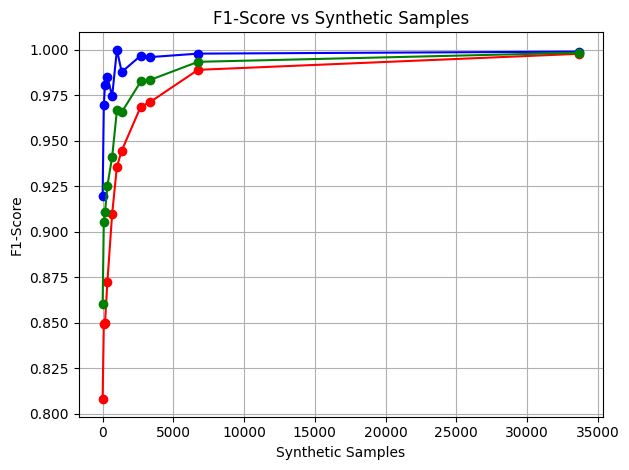

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the sizes of synthetic fraud samples to generate
synthetic_sizes = [0, 84, 168, 337, 674, 1011, 1348, 2696, 3370, 6740, 33700]

# Store results in a table
results = []

# Function to generate synthetic fraud samples
def generate_synthetic_samples(size):
    vaegan.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        z = torch.randn(size, latent_dim)  # Random latent vectors
        synthetic_samples1 = vaegan.generator1.decode(z).cpu().numpy()
        synthetic_samples2 = vaegan.generator2.decode(z).cpu().numpy()
        synthetic_samples = (synthetic_samples1 + synthetic_samples2) / 2  # Average outputs
        synthetic_samples = scaler.inverse_transform(synthetic_samples)  # Inverse transform
        synthetic_fraud_df = pd.DataFrame(synthetic_samples, columns=fraud_df.columns)
        synthetic_fraud_df['Class'] = 1  # Add 'Class' column
    return synthetic_fraud_df

# Iterate over different synthetic sample sizes
for size in synthetic_sizes:
    print(f"Training with {size} synthetic fraud samples...")

    # Generate synthetic fraud samples
    if size > 0:
        synthetic_fraud_df = generate_synthetic_samples(size)
        combined_df = pd.concat([df, synthetic_fraud_df], ignore_index=True)
    else:
        combined_df = df.copy()  # No synthetic samples

    # Shuffle the combined dataset
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Prepare the dataset for XGBoost
    X = combined_df.drop(['Class'], axis=1)
    y = combined_df['Class']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the XGBoost model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results.append({
        'Synthetic Samples': size,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results table
print("Results Table:")
print(results_df)

# Plot the results
# plt.figure(figsize=(12, 6))

# Precision Plot
plt.plot(results_df['Synthetic Samples'], results_df['Precision'], marker='o', color='b')
plt.title('Precision vs Synthetic Samples')
plt.xlabel('Synthetic Samples')
plt.ylabel('Precision')
plt.grid()


plt.plot(results_df['Synthetic Samples'], results_df['Recall'], marker='o', color='r')
plt.title('Recall vs Synthetic Samples')
plt.xlabel('Synthetic Samples')
plt.ylabel('Recall')
plt.grid()

# F1-Score Plot
plt.plot(results_df['Synthetic Samples'], results_df['F1-Score'], marker='o', color='g')
plt.title('F1-Score vs Synthetic Samples')
plt.xlabel('Synthetic Samples')
plt.ylabel('F1-Score')
plt.grid()

plt.tight_layout()
plt.show()

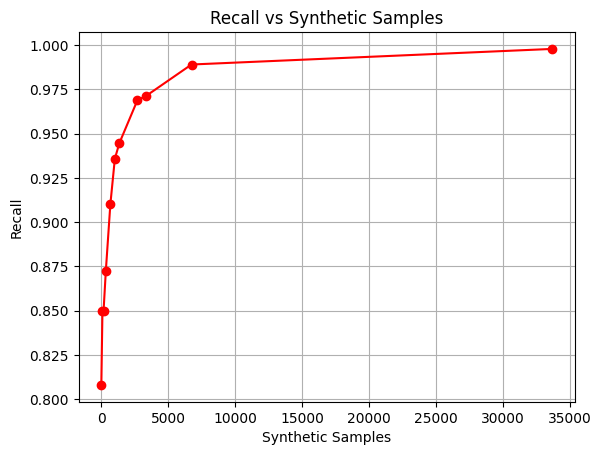

In [ ]:
plt.plot(results_df['Synthetic Samples'], results_df['Recall'], marker='o', color='r')
plt.title('Recall vs Synthetic Samples')
plt.xlabel('Synthetic Samples')
plt.ylabel('Recall')
plt.grid()

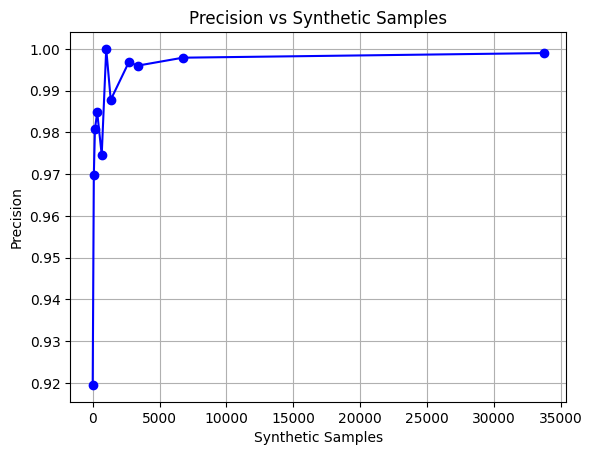

In [ ]:
# Precision Plot
plt.plot(results_df['Synthetic Samples'], results_df['Precision'], marker='o', color='b')
plt.title('Precision vs Synthetic Samples')
plt.xlabel('Synthetic Samples')
plt.ylabel('Precision')
plt.grid()

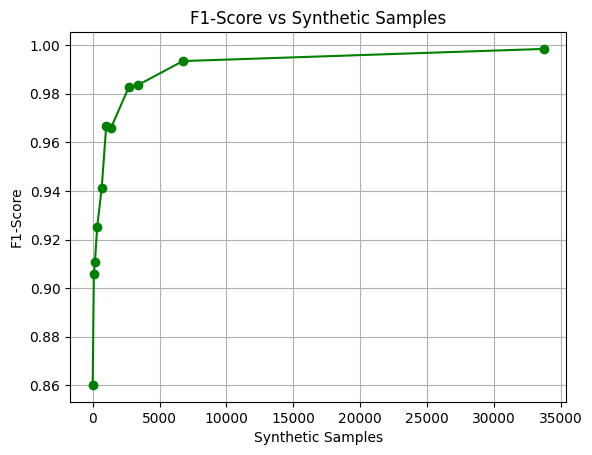

In [ ]:
plt.plot(results_df['Synthetic Samples'], results_df['F1-Score'], marker='o', color='g')
plt.title('F1-Score vs Synthetic Samples')
plt.xlabel('Synthetic Samples')
plt.ylabel('F1-Score')
plt.grid()

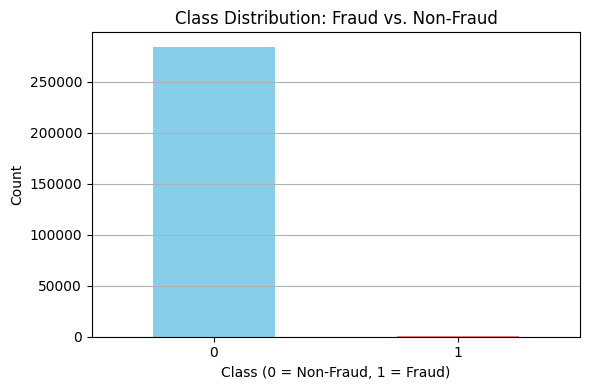

In [ ]:
plt.figure(figsize=(6,4))
df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Fraud vs. Non-Fraud')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


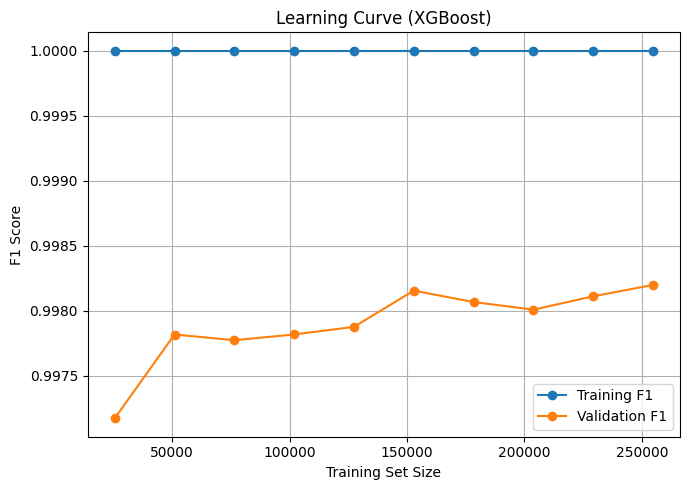

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X, y, cv=5, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training F1')
plt.plot(train_sizes, test_mean, 'o-', label='Validation F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (XGBoost)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


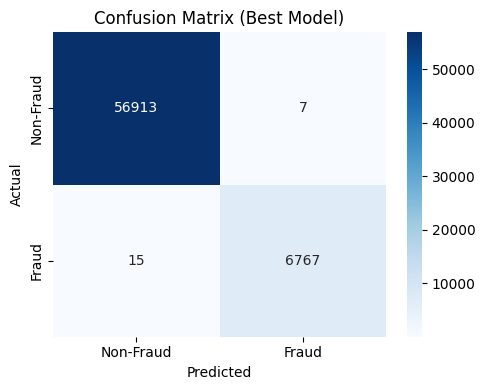

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


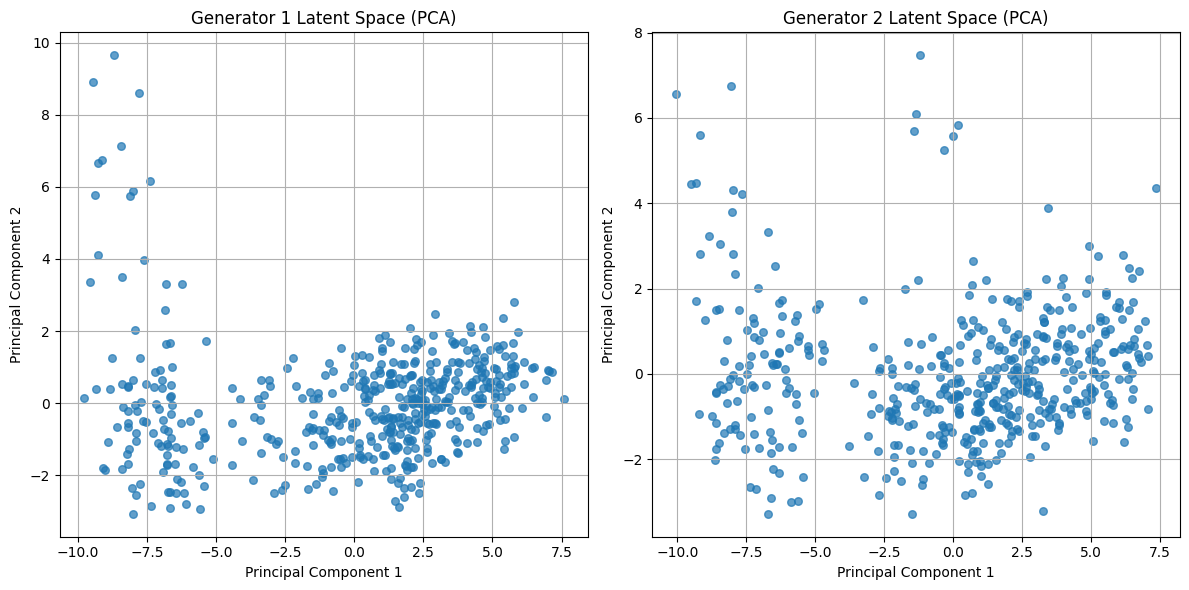

In [ ]:
# Extract latent representations of fraud samples
with torch.no_grad():
    mu1, logvar1 = vaegan.generator1.encode(fraud_data)
    mu2, logvar2 = vaegan.generator2.encode(fraud_data)

    z1 = vaegan.generator1.reparameterize(mu1, logvar1).cpu().numpy()
    z2 = vaegan.generator2.reparameterize(mu2, logvar2).cpu().numpy()

# Apply PCA to reduce to 2 dimensions for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z1_pca = pca.fit_transform(z1)
z2_pca = pca.fit_transform(z2)

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(z1_pca[:, 0], z1_pca[:, 1], alpha=0.7, s=30)
plt.title('Generator 1 Latent Space (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(z2_pca[:, 0], z2_pca[:, 1], alpha=0.7, s=30)
plt.title('Generator 2 Latent Space (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

plt.tight_layout()
plt.savefig('latent_space.png', dpi=300)
plt.show()

<Figure size 1200x800 with 0 Axes>

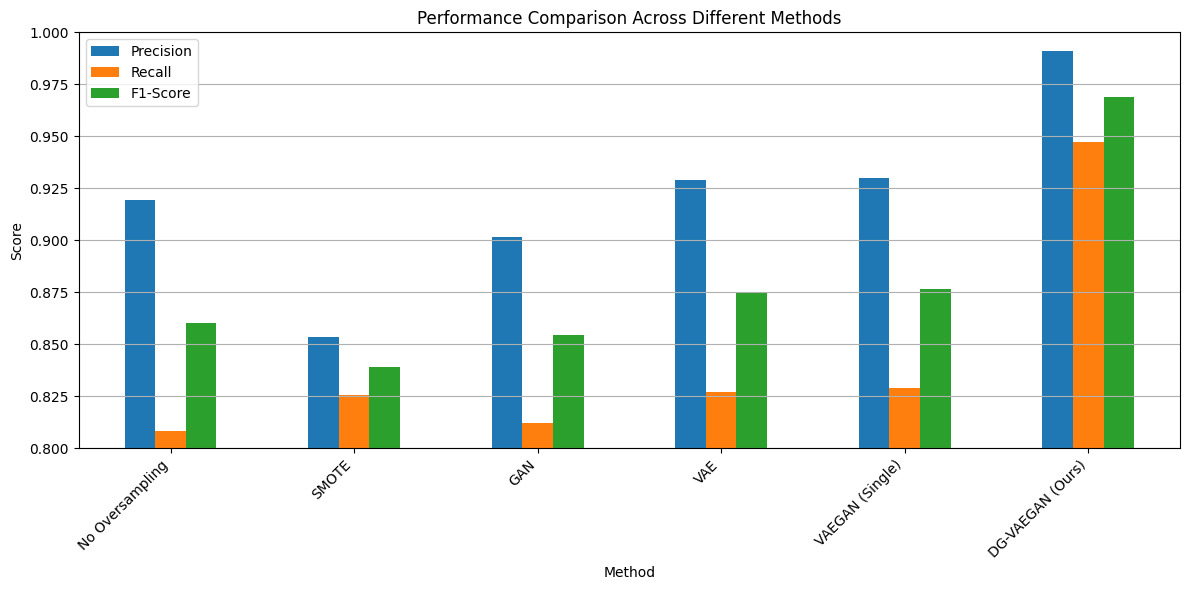

In [ ]:
# Define methods and their performance metrics
methods = ['No Oversampling', 'SMOTE', 'GAN', 'VAE', 'VAEGAN (Single)', 'DG-VAEGAN (Ours)']
precision_values = [0.9195, 0.8533, 0.9017, 0.9288, 0.9298, 0.9909]
recall_values = [0.8081, 0.8258, 0.8122, 0.8271, 0.8290, 0.9475]
f1_values = [0.8602, 0.8390, 0.8546, 0.8750, 0.8765, 0.9687]

# Create DataFrame
comparison_df = pd.DataFrame({
    'Method': methods,
    'Precision': precision_values,
    'Recall': recall_values,
    'F1-Score': f1_values
})

# Plot
plt.figure(figsize=(12, 8))
comparison_df.set_index('Method').plot(kind='bar', figsize=(12, 6))
plt.title('Performance Comparison Across Different Methods')
plt.ylabel('Score')
plt.ylim([0.8, 1.0])  # Adjust as needed for better visualization
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('method_comparison.png', dpi=300)
plt.show()